In [1]:
import tensorflow as tf
# from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from PIL import Image
from scipy import misc
import os
# import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def conv2d(x, W, s):
    return tf.nn.conv2d(x, W, strides=[1, s, s, 1], padding = 'SAME')
def deconv2d(x, W, output_shape, s):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, s, s, 1], padding = 'SAME')


In [3]:
def get_image(img_path):
#     img = misc.imread(img_path)/255. - 0.5
    img = misc.imread(img_path)
#     img = img[..., ::-1]  # rgb to bgr
    return img

def batch(batch_size, ls):
    index = (np.random.sample(batch_size)*202599).astype(int)
    ls_x = ls[[index]]
    return np.array([np.reshape(misc.imread("./img_align_celeba/"+x), 116412)/255. for x in ls_x])

class layer:
    def __init__(self, in_size, out_size):
        self.W = tf.Variable(tf.random_normal([in_size, out_size], mean=0.0, stddev=0.1))
        self.b = tf.Variable(tf.random_normal([1, out_size], mean=0.0, stddev=0.1))
    def output(self, inputs, activation_function=None):
        if activation_function == None:
            return tf.matmul(inputs, self.W) + self.b
        else :
            return activation_function(tf.matmul(inputs, self.W) + self.b)

def weight_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.1)
    return tf.Variable(initial)

In [4]:
batch_size = 90
g_dim = 100

ls = np.array(os.listdir("./img_align_celeba"))


In [5]:
layer_e1 = layer(28*23*72, 1024)
layer_e2 = layer(1024, g_dim)

layer_d1 = layer(g_dim, 1024)
layer_d2 = layer(1024, 28*23*72)

layer_g1 = layer(g_dim, 1024)
layer_g2 = layer(1024, 28*23*72)

encoder_var = {
    "W_e_conv1" : weight_variable([3,3, 3,24]),
    "W_e_conv2" : weight_variable([3,3,24,24]),
    "W_e_conv3" : weight_variable([3,3,24,48]),
    "W_e_conv4" : weight_variable([3,3,48,48]),
    "W_e_conv5" : weight_variable([3,3,48,72]),
    "W_e_conv6" : weight_variable([3,3,72,72]),
#     "W_e_conv3" : weight_variable([3,3,64,128]),
    "b_e_conv1" : bias_variable([24]),   
    "b_e_conv2" : bias_variable([24]),
    "b_e_conv3" : bias_variable([48]),
    "b_e_conv4" : bias_variable([48]),   
    "b_e_conv5" : bias_variable([72]),
    "b_e_conv6" : bias_variable([72])
#     "b_e_conv3" : bias_variable([128])
}

decoder_var = {
    "W_d_conv1" : weight_variable([3,3,72,72]),
    "W_d_conv2" : weight_variable([3,3,48,72]),
    "W_d_conv3" : weight_variable([3,3,48,48]),
    "W_d_conv4" : weight_variable([3,3,24,48]),
    "W_d_conv5" : weight_variable([3,3,24,24]),
    "W_d_conv6" : weight_variable([3,3, 3,24]),
    
    "b_d_conv1" : bias_variable([72]),
    "b_d_conv2" : bias_variable([48]),
    "b_d_conv3" : bias_variable([48]),
    "b_d_conv4" : bias_variable([24]),
    "b_d_conv5" : bias_variable([24]),
    "b_d_conv6" : bias_variable([3])
}

generator_var = {
    "W_g_conv1" : weight_variable([3,3,72,72]),
    "W_g_conv2" : weight_variable([3,3,48,72]),
    "W_g_conv3" : weight_variable([3,3,48,48]),
    "W_g_conv4" : weight_variable([3,3,24,48]),
    "W_g_conv5" : weight_variable([3,3,24,24]),
    "W_g_conv6" : weight_variable([3,3, 3,24]),
    
    "b_g_conv1" : bias_variable([72]),
    "b_g_conv2" : bias_variable([48]),
    "b_g_conv3" : bias_variable([48]),
    "b_g_conv4" : bias_variable([24]),
    "b_g_conv5" : bias_variable([24]),
    "b_g_conv6" : bias_variable([3])
}

var_d = [encoder_var[e] for e in encoder_var]+[decoder_var[d] for d in decoder_var]+[layer_e1.W, layer_e1.b, layer_e2.W, layer_e2.b, layer_d1.W, layer_d1.b, layer_d2.W, layer_d2.b]
var_g = [generator_var[g] for g in generator_var]+[layer_g1.W, layer_g1.b, layer_g2.W, layer_g2.b]


In [6]:
def encoder(x):
    x_origin = tf.reshape(x, [-1,218,178,3])      #28x28x1
    h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, encoder_var["W_e_conv1"], 1), encoder_var["b_e_conv1"]))     #14x14x16
    h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_conv1, encoder_var["W_e_conv2"], 2), encoder_var["b_e_conv2"]))    #7x7x32
    
    h_e_conv3 = tf.nn.relu(tf.add(conv2d(h_e_conv2, encoder_var["W_e_conv3"], 1), encoder_var["b_e_conv3"]))    #4x4x64
    h_e_conv4 = tf.nn.relu(tf.add(conv2d(h_e_conv3, encoder_var["W_e_conv4"], 2), encoder_var["b_e_conv4"]))    #4x4x64
    
    h_e_conv5 = tf.nn.relu(tf.add(conv2d(h_e_conv4, encoder_var["W_e_conv5"], 1), encoder_var["b_e_conv5"]))    #4x4x64
    h_e_conv6 = tf.nn.relu(tf.add(conv2d(h_e_conv5, encoder_var["W_e_conv6"], 2), encoder_var["b_e_conv6"]))    #4x4x64
    
    h_e_conv6_reshape = tf.reshape(h_e_conv6, [-1,28*23*72])
    h_e_layer1 = layer_e1.output(h_e_conv6_reshape, tf.nn.relu)
    h_e_layer2 = layer_e2.output(h_e_layer1, tf.nn.relu)
#     h_e_layer = layer_e.output(h_e_conv3_reshape, tf.nn.sigmoid)
    return h_e_layer2


In [7]:
def decoder(z):
    h_d_layer1 = layer_d1.output(z, tf.nn.relu)
    h_d_layer2 = layer_d2.output(h_d_layer1, tf.nn.relu)
#     h_d_layer = layer_d.output(z, tf.nn.sigmoid)
    h_d_layer_reshape = tf.reshape(h_d_layer2, [-1,28,23,72])
    
    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 55, 45, 72])
    h_d_conv1 = tf.nn.relu(deconv2d(h_d_layer_reshape, decoder_var["W_d_conv1"], output_shape_d_conv1, 2)+decoder_var["b_d_conv1"])
    output_shape_d_conv2 = tf.stack([tf.shape(z)[0], 55, 45, 48])
    h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, decoder_var["W_d_conv2"], output_shape_d_conv2, 1)+decoder_var["b_d_conv2"])

    output_shape_d_conv3 = tf.stack([tf.shape(z)[0], 109, 89, 48])
    h_d_conv3 = tf.nn.relu(deconv2d(h_d_conv2, decoder_var["W_d_conv3"], output_shape_d_conv3, 2)+decoder_var["b_d_conv3"])
    output_shape_d_conv4 = tf.stack([tf.shape(z)[0], 109, 89, 24])
    h_d_conv4 = tf.nn.relu(deconv2d(h_d_conv3, decoder_var["W_d_conv4"], output_shape_d_conv4, 1)+decoder_var["b_d_conv4"])

    output_shape_d_conv5 = tf.stack([tf.shape(z)[0], 218, 178, 24])
    h_d_conv5 = tf.nn.relu(deconv2d(h_d_conv4, decoder_var["W_d_conv5"], output_shape_d_conv5, 2)+decoder_var["b_d_conv5"])
    output_shape_d_conv6 = tf.stack([tf.shape(z)[0], 218, 178, 3])
    h_d_conv6 = tf.nn.relu(deconv2d(h_d_conv5, decoder_var["W_d_conv6"], output_shape_d_conv6, 1)+decoder_var["b_d_conv6"])
    
    return h_d_conv6



In [8]:
def generator(z):
    h_g_layer1 = layer_g1.output(z, tf.nn.relu)
    h_g_layer2 = layer_g2.output(h_g_layer1, tf.nn.relu)
#     h_g_layer = layer_g.output(z, tf.nn.sigmoid)
    h_g_layer_reshape = tf.reshape(h_g_layer2, [-1,28,23,72])
    
    output_shape_g_conv1 = tf.stack([tf.shape(z)[0], 55, 45, 72])
    h_g_conv1 = tf.nn.relu(deconv2d(h_g_layer_reshape, generator_var["W_g_conv1"], output_shape_g_conv1, 2)+generator_var["b_g_conv1"])
    output_shape_g_conv2 = tf.stack([tf.shape(z)[0], 55, 45, 48])
    h_g_conv2 = tf.nn.relu(deconv2d(h_g_conv1, generator_var["W_g_conv2"], output_shape_g_conv2, 1)+generator_var["b_g_conv2"])

    output_shape_g_conv3 = tf.stack([tf.shape(z)[0], 109, 89, 48])
    h_g_conv3 = tf.nn.relu(deconv2d(h_g_conv2, generator_var["W_g_conv3"], output_shape_g_conv3, 2)+generator_var["b_g_conv3"])
    output_shape_g_conv4 = tf.stack([tf.shape(z)[0], 109, 89, 24])
    h_g_conv4 = tf.nn.relu(deconv2d(h_g_conv3, generator_var["W_g_conv4"], output_shape_g_conv4, 1)+generator_var["b_g_conv4"])

    output_shape_g_conv5 = tf.stack([tf.shape(z)[0], 218, 178, 24])
    h_g_conv5 = tf.nn.relu(deconv2d(h_g_conv4, generator_var["W_g_conv5"], output_shape_g_conv5, 2)+generator_var["b_g_conv5"])
    output_shape_g_conv6 = tf.stack([tf.shape(z)[0], 218, 178, 3])
    h_g_conv6 = tf.nn.relu(deconv2d(h_g_conv5, generator_var["W_g_conv6"], output_shape_g_conv6, 1)+generator_var["b_g_conv6"])
    
    return h_g_conv6

def discriminator(x):
    return decoder(encoder(x))

In [9]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def loss(x):
#     return tf.reduce_mean(tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2))
    return tf.reduce_mean(tf.abs(tf.reshape(x, [-1, 116412]) - tf.reshape(discriminator(x), [-1, 116412])))
#     return tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2)

In [10]:
x_d = tf.placeholder(tf.float32, shape = [None, 116412])
x_g = tf.placeholder(tf.float32, shape = [None, g_dim])


In [11]:
gamma = 0.5
# k_t = 0.
k_t = tf.Variable(0.0, tf.float32)


d_loss = tf.reduce_mean(loss(x_d)-k_t*loss(generator(x_g)))
# d_loss = tf.reduce_mean(-k_t*loss(generator(x_g)))
# d_loss = tf.reduce_mean(loss(x_d))

# g_loss = loss(generator(x_g))
g_loss = tf.reduce_mean(loss(generator(x_g)))

g_sample = generator(x_g)

M_global = loss(x_d) + tf.abs(gamma*loss(x_d) - loss(generator(x_g)))

d_optimizer = tf.train.AdamOptimizer(0.0001).minimize(d_loss, var_list= var_d)
g_optimizer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list= var_g)

# balancer = gamma*loss(x_d) - loss(generator(x_g))
balancer = tf.reduce_mean(gamma*loss(x_d) - loss(generator(x_g)))
# update_k = k_t.assign(k_t + 0.001 * balancer)
update_k = k_t.assign(tf.clip_by_value(k_t + 0.001 * balancer, 0, 1))

In [12]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(1001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%100==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 12.7157  g-loss: 12.6721 k_t: 0.0 M_global: 19.03
step: 100  d-loss: 0.356211  g-loss: 0.149278 k_t: 0.00346832 M_global: 0.385816
step: 200  d-loss: 0.323421  g-loss: 0.20548 k_t: 0.00283531 M_global: 0.367482
step: 300  d-loss: 0.295824  g-loss: 0.246927 k_t: 0.0 M_global: 0.394839
step: 400  d-loss: 0.288324  g-loss: 0.239045 k_t: 0.0 M_global: 0.383208
step: 500  d-loss: 0.27033  g-loss: 0.204543 k_t: 0.0 M_global: 0.339708
step: 600  d-loss: 0.260372  g-loss: 0.18298 k_t: 0.0 M_global: 0.313166
step: 700  d-loss: 0.260423  g-loss: 0.162927 k_t: 0.0 M_global: 0.293139
step: 800  d-loss: 0.24888  g-loss: 0.137844 k_t: 0.0 M_global: 0.262284
step: 900  d-loss: 0.252881  g-loss: 0.124175 k_t: 6.43305e-06 M_global: 0.255147
step: 1000  d-loss: 0.245818  g-loss: 0.102144 k_t: 0.00105677 M_global: 0.266745


In [13]:
gg_batch = batch(20, ls)
zz = sample_Z(batch_size, g_dim)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


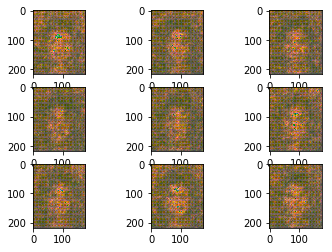

In [14]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

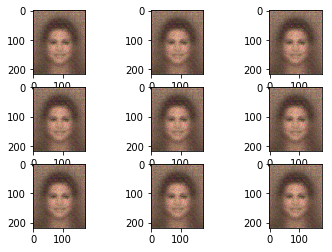

In [17]:
gg = sess.run(discriminator(x_d), feed_dict = {x_d: gg_batch})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [18]:
for step in range(1001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%100==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 0.235674  g-loss: 0.060431 k_t: 0.0501407 M_global: 0.297625
step: 100  d-loss: 0.244309  g-loss: 0.0603494 k_t: 0.0560516 M_global: 0.311189
step: 200  d-loss: 0.230562  g-loss: 0.0575441 k_t: 0.0620523 M_global: 0.293655
step: 300  d-loss: 0.241262  g-loss: 0.035305 k_t: 0.0702328 M_global: 0.330308
step: 400  d-loss: 0.238821  g-loss: 0.0373451 k_t: 0.0787013 M_global: 0.325295
step: 500  d-loss: 0.225375  g-loss: 0.0367164 k_t: 0.0871139 M_global: 0.306144
step: 600  d-loss: 0.235702  g-loss: 0.0377628 k_t: 0.0954178 M_global: 0.321195
step: 700  d-loss: 0.237133  g-loss: 0.039276 k_t: 0.103533 M_global: 0.322523
step: 800  d-loss: 0.232802  g-loss: 0.0407373 k_t: 0.111508 M_global: 0.31528
step: 900  d-loss: 0.234379  g-loss: 0.0434931 k_t: 0.119349 M_global: 0.315862
step: 1000  d-loss: 0.229376  g-loss: 0.0453084 k_t: 0.12694 M_global: 0.307382


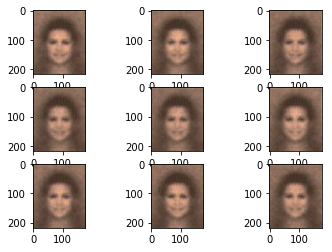

In [19]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

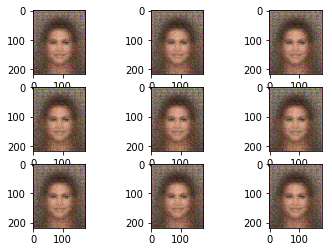

In [20]:
# gg_z = sess.run(g_sample, feed_dict = {x_g: zz})
gg = sess.run(discriminator(x_d), feed_dict = {x_d: gg_batch})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: gg_z})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [21]:
for step in range(1001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%100==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 0.232821  g-loss: 0.0452503 k_t: 0.127014 M_global: 0.312603
step: 100  d-loss: 0.236997  g-loss: 0.0491184 k_t: 0.134326 M_global: 0.316274
step: 200  d-loss: 0.231221  g-loss: 0.0513457 k_t: 0.141335 M_global: 0.306371
step: 300  d-loss: 0.232695  g-loss: 0.0549669 k_t: 0.148065 M_global: 0.306284
step: 400  d-loss: 0.244389  g-loss: 0.0587316 k_t: 0.154458 M_global: 0.32146
step: 500  d-loss: 0.234647  g-loss: 0.06406 k_t: 0.16046 M_global: 0.303329
step: 600  d-loss: 0.23357  g-loss: 0.0693694 k_t: 0.16604 M_global: 0.298263
step: 700  d-loss: 0.235326  g-loss: 0.070797 k_t: 0.171284 M_global: 0.300382
step: 800  d-loss: 0.221455  g-loss: 0.0697147 k_t: 0.176404 M_global: 0.280915
step: 900  d-loss: 0.233785  g-loss: 0.0696863 k_t: 0.181547 M_global: 0.299967
step: 1000  d-loss: 0.235849  g-loss: 0.0594106 k_t: 0.187082 M_global: 0.311034


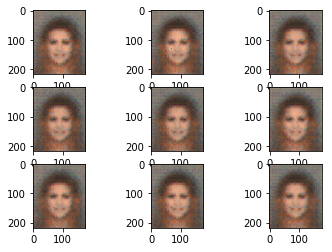

In [22]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

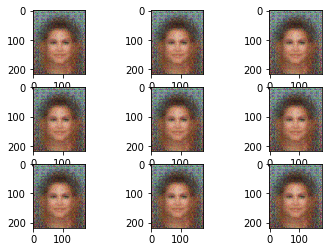

In [23]:
gg = sess.run(discriminator(x_d), feed_dict = {x_d: gg_batch})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [24]:
for step in range(10001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 0.231302  g-loss: 0.059605 k_t: 0.187144 M_global: 0.304081
step: 1000  d-loss: 0.232403  g-loss: 0.0748691 k_t: 0.245062 M_global: 0.301256
step: 2000  d-loss: 0.223532  g-loss: 0.087637 k_t: 0.287149 M_global: 0.285409
step: 3000  d-loss: 0.218681  g-loss: 0.0976727 k_t: 0.32118 M_global: 0.277405
step: 4000  d-loss: 0.212963  g-loss: 0.116219 k_t: 0.339488 M_global: 0.262408
step: 5000  d-loss: 0.214472  g-loss: 0.116436 k_t: 0.351515 M_global: 0.266666
step: 6000  d-loss: 0.21714  g-loss: 0.117409 k_t: 0.363399 M_global: 0.272301
step: 7000  d-loss: 0.214149  g-loss: 0.120546 k_t: 0.374505 M_global: 0.268394
step: 8000  d-loss: 0.217571  g-loss: 0.126807 k_t: 0.382179 M_global: 0.272244
step: 9000  d-loss: 0.213989  g-loss: 0.128301 k_t: 0.385311 M_global: 0.266837
step: 10000  d-loss: 0.217337  g-loss: 0.135191 k_t: 0.384126 M_global: 0.269824


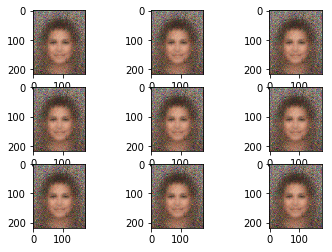

In [25]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

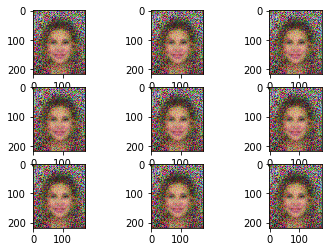

In [26]:
gg = sess.run(discriminator(x_d), feed_dict = {x_d: gg_batch})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [27]:
for step in range(10001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 0.206853  g-loss: 0.134982 k_t: 0.38412 M_global: 0.264334
step: 1000  d-loss: 0.211176  g-loss: 0.136061 k_t: 0.379937 M_global: 0.267496
step: 2000  d-loss: 0.206376  g-loss: 0.137535 k_t: 0.374621 M_global: 0.266484
step: 3000  d-loss: 0.208174  g-loss: 0.13544 k_t: 0.3688 M_global: 0.264503
step: 4000  d-loss: 0.211054  g-loss: 0.138226 k_t: 0.362967 M_global: 0.268839
step: 5000  d-loss: 0.209662  g-loss: 0.136266 k_t: 0.357505 M_global: 0.265455
step: 6000  d-loss: 0.211927  g-loss: 0.137186 k_t: 0.352379 M_global: 0.26732
step: 7000  d-loss: 0.218618  g-loss: 0.138035 k_t: 0.347943 M_global: 0.271358
step: 8000  d-loss: 0.222336  g-loss: 0.133408 k_t: 0.343963 M_global: 0.268927
step: 9000  d-loss: 0.218179  g-loss: 0.132045 k_t: 0.340376 M_global: 0.263607
step: 10000  d-loss: 0.220029  g-loss: 0.132243 k_t: 0.337084 M_global: 0.264666


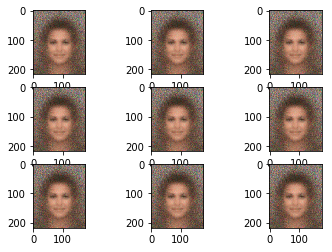

In [28]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

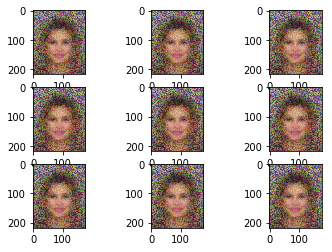

In [29]:
gg = sess.run(discriminator(x_d), feed_dict = {x_d: gg_batch})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [30]:
for step in range(10001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 0.211179  g-loss: 0.132364 k_t: 0.33708 M_global: 0.260261
step: 1000  d-loss: 0.212204  g-loss: 0.131215 k_t: 0.33436 M_global: 0.259254
step: 2000  d-loss: 0.21049  g-loss: 0.13373 k_t: 0.331789 M_global: 0.261161
step: 3000  d-loss: 0.218028  g-loss: 0.131904 k_t: 0.329522 M_global: 0.262651
step: 4000  d-loss: 0.209694  g-loss: 0.128711 k_t: 0.327584 M_global: 0.25464
step: 5000  d-loss: 0.209672  g-loss: 0.129959 k_t: 0.325737 M_global: 0.255962
step: 6000  d-loss: 0.222881  g-loss: 0.129779 k_t: 0.323875 M_global: 0.267591
step: 7000  d-loss: 0.21274  g-loss: 0.13185 k_t: 0.322507 M_global: 0.259481
step: 8000  d-loss: 0.212797  g-loss: 0.127286 k_t: 0.321554 M_global: 0.254149
step: 9000  d-loss: 0.21367  g-loss: 0.129243 k_t: 0.320185 M_global: 0.256769
step: 10000  d-loss: 0.220618  g-loss: 0.131375 k_t: 0.318823 M_global: 0.262627


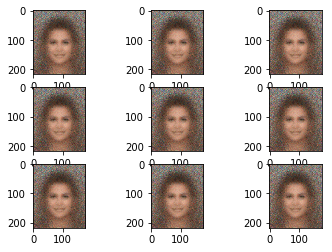

In [31]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


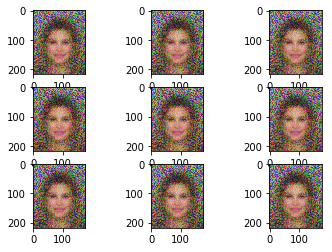

In [43]:

gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})

gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

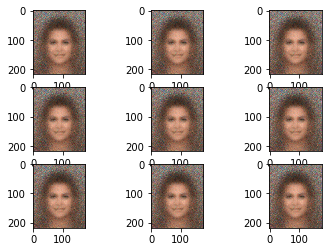

In [45]:
gg_z = sess.run(tf.reshape(g_sample, [-1,116412]), feed_dict = {x_g: zz})
gg = sess.run(discriminator(x_d), feed_dict = {x_d: gg_z})

gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg_z])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

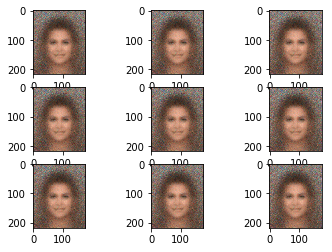

In [41]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [ ]:
gg = sess.run(discriminator(x_d), feed_dict = {x_d: gg_batch})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [ ]:
for step in range(10001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

In [ ]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [ ]:
gg = sess.run(discriminator(x_d), feed_dict = {x_d: gg_batch})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [ ]:
for step in range(50001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

In [ ]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [ ]:
gg = sess.run(discriminator(x_d), feed_dict = {x_d: gg_batch})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [ ]:
for step in range(50001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

In [ ]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [ ]:
gg = sess.run(discriminator(x_d), feed_dict = {x_d: gg_batch})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])